### Finetuning BERT base on SST2 Dataset  

The preprocessing functions defined in the `Preprocessing SST2, IMDb, Yelp Datasets.ipynb` jupyter notebook were used.

In [1]:
import torch
import numpy as np
import pandas as pd 
from transformers.models.bert.modeling_bert import BertForSequenceClassification
from transformers import AutoTokenizer, BertConfig
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from datasets import load_dataset, load_metric 
import datasets
import random
import matplotlib.pyplot as plt
import evaluate
import json

''' Taking a pretrained BERT (transformer-based) model and fine-tuning it on SST2 Dataset '''

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

2022-11-10 20:26:33.635021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 20:26:33.897412: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 20:26:34.384998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/weiming/miniconda3/envs/weiming/lib/
2022-11-10 20:26:34.385044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer

cuda:0


In [2]:
# Maximum sequence length that the transformer model will take in. Can range from 0-512. 
# Higher sequence length means the model will "look" at more words which results in better classification. 
seq_len = 128 

# Preprocessing the data - converting words into vectors using tokenizers
def preprocess_function(examples):
    return tokenizer(examples["sentence"],  max_length=seq_len, padding = "max_length", truncation=True,)

def compute_metrics(eval_preds):
    metric = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Creating a Customer Trainer which overwrites the logging method to log training accuracy 
### after every epoch so that we can plot the training accuracy vs validation accuracy curve
class CustomTrainer(Trainer):
    def _maybe_log_save_evaluate(self, tr_loss, model, trial, epoch, ignore_keys_for_eval):
        if self.control.should_log:

            logs: Dict[str, float] = {}

            # all_gather + mean() to get average loss over all processes
            tr_loss_scalar = self._nested_gather(tr_loss).mean().item()

            # reset tr_loss to zero
            tr_loss -= tr_loss
            
            
            logs["loss"] = round(tr_loss_scalar / (self.state.global_step - self._globalstep_last_logged), 4)
            logs["accuracy"] = self.predict(test_dataset=self.train_dataset, metric_key_prefix="train").metrics['train_accuracy']
            logs["learning_rate"] = self._get_learning_rate()

            self._total_loss_scalar += tr_loss_scalar
            self._globalstep_last_logged = self.state.global_step
            self.store_flos()

            self.log(logs)

        metrics = None
        if self.control.should_evaluate:
            metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)
            self._report_to_hp_search(trial, epoch, metrics)

        if self.control.should_save:
            self._save_checkpoint(model, trial, metrics=metrics)
            self.control = self.callback_handler.on_save(self.args, self.state, self.control)

### Function to extract training history from json file           
def get_history(filename):
    num_epochs_trained = 0
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    f = open(filename, "r")
    history = json.load(f)['log_history']
    
    for i in range(0, len(history), 2):
        num_epochs_trained += 1
        # Train 
        train_loss_list.append(history[i]['loss'])
        train_acc_list.append(history[i]['accuracy'])
        
        # Validation
        val_loss_list.append(history[i + 1]['eval_loss'])
        val_acc_list.append(history[i + 1]['eval_accuracy'])
    
    return num_epochs_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list



### Retrieving Dataset from HuggingFace Library

In [3]:
### Reference: https://huggingface.co/datasets/glue
dataset = load_dataset("glue", "sst2")
dataset

Found cached dataset glue (/home/weiming/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [4]:
print(f"# of Train Sequences: {len(dataset['train'])},\
        # of Validation Sequences: {len(dataset['validation'])}")

# of Train Sequences: 67349,        # of Validation Sequences: 872


### Show Random Sequences from Datasets

In [5]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    pd.set_option('display.max_colwidth', None)
    return df

In [6]:
show_random_elements(dataset["train"], 10)

,sentence,label,idx
0,'m sure there 's a teenage boy out there somewhere who 's dying for this kind of entertainment .,negative,14240
1,can do even more damage,negative,4200
2,but it also does the absolute last thing we need hollywood doing to us,negative,41645
3,heroic deserves a look,positive,29140
4,the long list of renegade-cop tales,negative,51002
5,is attractive .,positive,53119
6,", remains surprisingly idealistic",positive,11672
7,nutty cliches and far too much dialogue,negative,7176
8,"human nature is a goofball movie , in the way that malkovich was , but it tries too hard",negative,825
9,"vaguely interesting , but it 's just too too much",negative,20193


In [7]:
show_random_elements(dataset["validation"], 10)

,sentence,label,idx
0,"with virtually no interesting elements for an audience to focus on , chelsea walls is a triple-espresso endurance challenge .",negative,269
1,"not the kind of film that will appeal to a mainstream american audience , but there is a certain charm about the film that makes it a suitable entry into the fest circuit .",positive,772
2,the only excitement comes when the credits finally roll and you get to leave the theater .,negative,818
3,"instead of hiding pinocchio from critics , miramax should have hidden it from everyone .",negative,364
4,"a broad , melodramatic estrogen opera that 's pretty toxic in its own right .",negative,574
5,"an artful , intelligent film that stays within the confines of a well-established genre .",positive,206
6,"further proof that the epicenter of cool , beautiful , thought-provoking foreign cinema is smack-dab in the middle of dubya 's axis of evil .",positive,648
7,zaidan 's script has barely enough plot to string the stunts together and not quite enough characterization to keep the faces straight .,negative,592
8,"a misogynistic piece of filth that attempts to pass itself off as hip , young adult entertainment .",negative,188
9,"even if you do n't think ( kissinger 's ) any more guilty of criminal activity than most contemporary statesmen , he 'd sure make a courtroom trial great fun to watch .",positive,483


### Checking the Mapping of Labels for Training and Validation Dataset

In [8]:
print("Mapping of Labels for Training Dataset")
for i in range(dataset['train'].features['label'].num_classes):
    print(f"{i}: {dataset['train'].features['label'].int2str(i)}")

print()

print("Mapping of Labels for Validation Dataset")
for i in range(dataset['test'].features['label'].num_classes):
    print(f"{i}: {dataset['test'].features['label'].int2str(i)}")
    

Mapping of Labels for Training Dataset
0: negative
1: positive

Mapping of Labels for Validation Dataset
0: negative
1: positive


### Functions to Freeze BERT Layers

In [9]:
### Freeze all parameters from embedding layer to enc_layers_to_freeze layers
def freeze_bert_layers(model, enc_layers_to_freeze):
    # Freeze Embedding Layer
    for name, param in model.named_parameters():
        if "embeddings" in name:
            param.requires_grad = False
            
    # Freeze encoder layers from the encoder layer closest to the embedding layer
    for i in range(enc_layers_to_freeze):
        for name, param in model.named_parameters():
            if f"layer.{i}." in name:
                param.requires_grad = False
                
    return model

### Display all unfrozen parameters - sanity check
def print_unfrozen_layers(model):
    print("--------------Unfrozen Parameters--------------")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print(name)

### Finetuning BERT Base Uncased Model on SST2 Dataset

In [10]:
print(f"----Training BERT Base for SST2 Task----")

### Number of Epochs
epoch_no = 10
### Learning Rate
learning_rate = 2e-5
### Adjust the batch size to avoid out-of-memory errors
batch_size = 32 
### Select random seed for finetuning
seed = 0
### Dropout Probability
dropout_prob = 0.1 
### Number of encoder layers frozen
num_encoder_freeze = 2


### Define what pre-trained model checkpoint you want to use 
### Different pretrained models are available
### E.g. ['bert-base-uncased', 'distilbert-base-uncased', 'distilroberta', 'roberta-base',...]
### Different models have different training procedure and architecture and hence different performance
model_checkpoint = "bert-base-uncased"

### Tokenizer to preprocess the input before feeding into the model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, model_max_length = seq_len, )

### Convert every word (token) in the sequence in the dataset into integer for mapping by Embedding layer 
encoded_dataset = dataset.map(preprocess_function, batched=True)
print(len(encoded_dataset["train"]["input_ids"][0]))

### SST2 has just 2 labels - 0 (Negative) or 1 (Positive)
num_labels = 2

### Using pretrained bert-base-uncased for SST2 Sentiment Classification
### Classification dropout probability will follow hidden dropout probability by default
config = BertConfig(hidden_dropout_prob = dropout_prob, attention_probs_dropout_prob=dropout_prob, num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained(model_checkpoint,  config = config)
print(model)

### Freeze embedding layer and varying number of encoeder layers to prevent overfitting
model = freeze_bert_layers(model, num_encoder_freeze) 
print_unfrozen_layers(model)

### Introduce Early Stopping
earlystopping = EarlyStoppingCallback(early_stopping_patience=3)

print(f"Pretrained Model for SST2 Task: {model_checkpoint}")

### ---------------Define arguments for training---------------
###`TrainingArguments` is a class that contains all the attributes to customize 
### the training. It requires one folder name, which will be used to save the checkpoints 
### of the model, and all other arguments are optional:
training_args = TrainingArguments(
    f"./BERT-SST2-Seq128-{seed}", #Creates a directory named as provided
    evaluation_strategy = "epoch", # Evaluate every epoch
    save_strategy = "epoch", # Save every epoch
    logging_strategy = "epoch", # Log every epoch
    save_total_limit = 1, # Only save one epoch data (the best one)
    learning_rate=learning_rate, # Learning rate - typically 2e-5 is used
    per_device_train_batch_size=batch_size, # Training Batch Size
    per_device_eval_batch_size=batch_size, # Validation Batch Size
    num_train_epochs=epoch_no, # Number of Epochs
    weight_decay=0.01, #Weight regularization
    load_best_model_at_end=True, 
    metric_for_best_model="accuracy", # Criteria for "Best" model 
    optim="adamw_torch", #Optimizer
    warmup_ratio = 0.1, 
    seed=seed
)


trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=encoded_dataset["train"], # Train dataset
    eval_dataset=encoded_dataset["validation"], # Val dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[earlystopping]
)

# Call trainer.train to start training
trainer.train()

----Training BERT Base for SST2 Task----


Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-ea03f781165fb9c9.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-f2e28c94a405dca2.arrow


128


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 67349
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 21050
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### Plotting Training and Validation Loss and Accuracy Curves

Text(0.5, 1.0, 'Training vs Validation Accuracy')

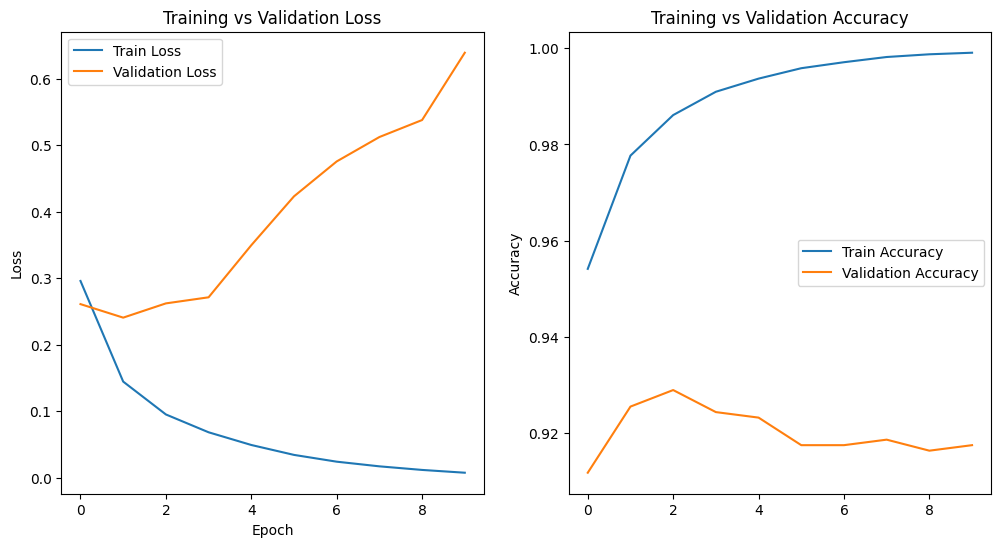

In [11]:
num_epochs_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list = get_history("./BERT-SST2-0/checkpoint-21050/trainer_state.json")

epoch_list = [i for i in range(num_epochs_trained)]
_, ax = plt.subplots(nrows = 1, ncols=2, figsize=(12,6))
ax[0].plot(epoch_list, train_loss_list)
ax[0].plot(epoch_list, val_loss_list)
ax[0].legend(["Train Loss", "Validation Loss"])
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training vs Validation Loss")

ax[1].plot(epoch_list, train_acc_list)
ax[1].plot(epoch_list, val_acc_list)
ax[1].legend(["Train Accuracy", "Validation Accuracy"])
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Training vs Validation Accuracy")